In [120]:

import datetime
from time import sleep
from binance.client import Client
import pandas as pd
import datetime
import time
import numpy as np
import os
import sys
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.stattools import coint

#from crontab import CronTab
from safe_schedule import SafeScheduler
#add your api keys here
api_key = 'XuozVlFg2WYVemwmHMqCK9j5jSYIV1z3MoDAXY76X2JiCbbgcw7dGxvE0eGVsqhH'
secret_key = 'WyWBCdczLCFvV8fKy16R5dOwhhjK31T7ZrW0cplIzjrvmlSPh5E1KEeAEh5c9I6s'

#Open location of recorded buy/sell walls
bw_location = '/home/me/Documents/BWA/data/watcher/buywalls/'
sw_location = '/home/me/Documents/BWA/data/watcher/sellwalls/'
save_port = 'home/me/Documents/BWA/data/bw_portfolios'
#Open binance client
client = Client(api_key, secret_key)
#get current time and format to compare with data
current_milli_time = lambda: int(round(time.time() * 1000))
now = str(current_milli_time())

def get_data(sym,prev_k,k,candle_k='5m'):
    prev_k = str(prev_k)
    k = str(k)
    #print("Before",prev_k,k)
    #fix to get data from selected timeframe
    
    #print("After",prev_k,k)
    data = client.get_historical_klines(sym,interval= candle_k,start_str =int(prev_k),end_str = int(k))
    #print(data)
    data = pd.DataFrame(data,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
    #data = data.fillna(method='ffill')
    # convert from millesecond time to datetime for potential resampling and readability
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data = data.set_index('Open time')
    data = data[['Open','High','Low','Close','Close time','Volume']].astype(float)
    return data

def normalize(data,column="Close",deci = False):
    if(deci==True):
        norm_close =  data[column].divide(data[column].iloc[0])-1
    else:
        norm_close =  data[column].divide(data[column].iloc[0])
    return norm_close

def get_n_day(df):
    #df = df[:288]
    #print(len(df))
    coins = df['Coin']
    cgroups = df.groupby('Coin')
    top_10 = list(df['Coin'].value_counts().head(10).keys())
    df['1D_freq'] = df.groupby('Coin')['Coin'].transform('count')
    df = df.sort_values(['1D_freq'],ascending=False)
    wall = []
    for i in top_10:
        wall.append(cgroups.get_group(i).iloc[-1].values)
    wall = pd.DataFrame(wall, columns=df.columns.tolist())
    wall = wall.set_index('Coin')
    
    return wall

def create_port(top10):
    portfolio = {}
    for coin in top10.index:
        print(coin)
        startTime = top10.loc[coin]['Date']
        
        #endTime=str(float(startTime)+240000)
        #print(float(endTime)-int(startTime))
        histData = client.get_historical_klines(coin,client.KLINE_INTERVAL_5MINUTE,'3 days ago')
        histData = pd.DataFrame(histData,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
        portfolio[coin] = histData
        #print()
    return portfolio, top10


def to_dt(v,is_milli=True):
    if(is_milli):
        v = datetime.datetime.fromtimestamp(int(v)/1000)
    else:
        v = datetime.datetime.fromtimestamp(int(v))
    return v

def get_freq_sig(loc):
    os.chdir(bw_location)
    files = filter(os.path.isfile,os.listdir(bw_location))
    files =  [int(f) for f in files]
    files = list(files)
    fs_df = pd.DataFrame(files)
    fs_df = fs_df[0].sort_values()
    st,end = to_dt(fs_df.iloc[0]),to_dt(fs_df.iloc[-1])
    bw_freq = []
    f_len = int(len(os.listdir(loc)))
    for c,i in enumerate(os.listdir(loc)):
        try:
            curr = pd.read_csv(loc+i)
        except Exception as e:
            print(i,e)
 
        curr.columns = ['Coin','Close','Profit','Loss','Date']  
        bw_freq.append(curr)
        if((c/f_len)%10==0):
            pct = str(int((c/f_len)*100))
            print("{}% of files loaded".format(pct))
    bw_freq = pd.concat(bw_freq)
    bw_freq = bw_freq[['Date','Coin','Close']]
    bw_freq.columns = ['Date','Coin','Close']
    bw_freq = bw_freq.sort_values(['Date'],ascending=False)
    #print(all_w.head(), len(all_w))
    #bw_freq['all_freq'] = bw_freq.groupby('Coin')['Coin'].transform('count')
    #bw_freq = bw_freq.sort_values(['Date'],ascending=False)    
    print(st,end)
    print(to_dt(now), now)
    print(fs_df.head())
    return bw_freq

def clean_fs(fs):
    fs =fs.drop_duplicates()
    fs = fs.sort_values(['Date'],axis=0)
    fs['Date_m'] = fs['Date']
    fs['Date'] = fs['Date']/1000
    fs['Date'] = fs['Date'].astype('datetime64[s]')

    rolling_f = {}
    f_col = []
    for i in fs.iterrows():
        coin = i[1][1]
        if(coin in rolling_f.keys()):
            rolling_f[coin] += 1
            f_col.append(rolling_f[coin])
        else:
            rolling_f[coin] = 1
            f_col.append(rolling_f[coin])
    print(len(fs),len(f_col))
    fs['rolling_freq'] = f_col
        
    return fs
    #files.sort(key=lambda x: os.path.getmtime(x))    

In [121]:
fs = get_freq_sig(bw_location)

0% of files loaded
17% of files loaded
35% of files loaded
52% of files loaded
70% of files loaded
87% of files loaded
2018-08-24 00:09:22.289000 2019-01-09 18:21:31.239000
2019-01-09 20:53:37.033000 1547085217033
12898    1535083762289
26843    1535084106238
6589     1535084444624
14497    1535084787792
20854    1535085130313
Name: 0, dtype: int64


In [122]:
fs_c = clean_fs(fs)
fs_c = fs_c.set_index(['Date','Coin'])
print(fs_c.head(3))
print(fs_c.tail(3))


87228 87228
                                Close         Date_m  rolling_freq
Date                Coin                                          
2018-08-24 04:09:22 ENGBTC   0.000099  1535083762289             1
                    DASHBTC  0.021344  1535083762289             1
2018-08-24 04:15:06 ENGBTC   0.000099  1535084106238             2
                                Close         Date_m  rolling_freq
Date                Coin                                          
2019-01-09 23:15:41 EDOBTC   0.000234  1547075741901           591
                    PIVXBTC  0.000222  1547075741901          1367
2019-01-09 23:21:31 PIVXBTC  0.000222  1547076091239          1368


Close  rolling_freq
Date                Coin                            
2018-08-24 04:09:22 ENGBTC    0.000099             1
                    DASHBTC   0.021344             1
2018-08-24 04:15:06 ENGBTC    0.000099             2
                    THETABTC  0.000015             1
2018-08-24 04:20:44 GVTBTC    0.000758             1
                    OAXBTC    0.000024             1
                    ENGBTC    0.000100             3
                    APPCBTC   0.000013             1
2018-08-24 04:26:27 GVTBTC    0.000754             2
                    ENGBTC    0.000099             4
                    AIONBTC   0.000074             1
2018-08-24 04:32:10 GVTBTC    0.000754             3
                    DASHBTC   0.021321             2
                    ENGBTC    0.000100             5
2018-08-24 04:37:52 ENGBTC    0.000099             6
                    DASHBTC   0.021328             3
                    GVTBTC    0.000754             4
2018-08-24 04:43:34 GVTBTC    0.000754             5
2018-08-24 04:49:17 GVTBTC    0.000754             6
2018-08-24 04:54:54 GVTBTC    0.000754             7
                    HCBTC     0.000413             1
                    WINGSBTC  0.000022             1
2018-08-24 05:00:35 WINGSBTC  0.000022             2
                    GVTBTC    0.000754             8
                    POLYBTC   0.000028             1
2018-08-24 05:06:16 THETABTC  0.000016             2
                    ARDRBTC   0.000016             1
                    POLYBTC   0.000028             2
                    GVTBTC    0.000757             9
2018-08-24 05:11:54 ZENBTC    0.003099             1
...                                ...           ...
2018-12-09 18:22:33 ARDRBTC   0.000015           728
2018-12-09 18:39:37 XLMBTC    0.000035           411
                    ETHBTC    0.026824           560
                    ARDRBTC   0.000015           729
2018-12-09 18:45:40 ARDRBTC   0.000015           730
                    BRDBTC    0.000056           872
2018-12-09 18:51:30 EDOBTC    0.000189           454
                    BRDBTC    0.000056           873
                    DGDBTC    0.004049           850
2018-12-09 18:57:16 GNTBTC    0.000020           320
                    SNMBTC    0.000006           817
                    EDOBTC    0.000189           455
2018-12-09 19:03:00 GNTBTC    0.000020           321
2018-12-09 19:08:48 ARDRBTC   0.000015           731
                    BRDBTC    0.000056           874
2018-12-09 19:14:34 ARDRBTC   0.000015           732
2018-12-09 19:20:18 GVTBTC    0.001035           999
                    BRDBTC    0.000056           875
                    ARNBTC    0.000071           517
2018-12-09 19:25:57 ARNBTC    0.000071           518
                    EDOBTC    0.000190           456
2018-12-09 19:31:48 ARDRBTC   0.000015           733
                    EDOBTC    0.000189           457
                    ARNBTC    0.000071           519
2018-12-09 19:43:28 EDOBTC    0.000189           458
                    BRDBTC    0.000056           876
                    ARDRBTC   0.000015           734
2018-12-09 19:49:30 BRDBTC    0.000056           877
                    EDOBTC    0.000189           459
                    ARDRBTC   0.000015           735

[71055 rows x 2 columns]

In [198]:
def unix_time_millis(dt):
    epoch = datetime.datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000.0



def interval(intv,st,end):
    out = pd.DataFrame()
    m_10 = []
    prev = st
    while(prev<end):
        curr = prev+int(86400000*intv)
        n = to_dt(curr).strftime('%Y-%m-%d')
        p = to_dt(prev).strftime('%Y-%m-%d')
        #
        print(p,"  |  ",n)
        
        prev = curr
        p = datetime.datetime.strptime(p, '%Y-%m-%d')
        n = datetime.datetime.strptime(n, '%Y-%m-%d')
        data = fs_c.loc[p:n]
        print(data.sort_values('rolling_freq',ascending=False))
        out = pd.concat([out,data],axis=0)
        break
    return out.sort_index()

st,end = fs_c.index[0][0],fs_c.index[-1][0]
st,end = unix_time_millis(st),unix_time_millis(end)
#get multiindex frequency dataframe
intv = 30
freq_df = interval(intv,st,end)

2018-08-24   |   2018-09-23
                                 Close         Date_m  rolling_freq
Date                Coin                                           
2018-09-22 23:07:47 BTGBTC    0.003348  1537657667944           696
2018-09-22 21:28:03 BTGBTC    0.003349  1537651683217           695
2018-09-22 16:19:04 BTGBTC    0.003332  1537633144072           694
2018-09-22 16:07:34 BTGBTC    0.003329  1537632454921           693
2018-09-21 07:36:04 MODBTC    0.000099  1537515364886           692
2018-09-22 16:01:42 BTGBTC    0.003331  1537632102359           692
2018-09-21 07:30:26 MODBTC    0.000099  1537515026373           691
2018-09-22 15:50:02 BTGBTC    0.003333  1537631402717           691
2018-09-21 07:24:47 MODBTC    0.000099  1537514687285           690
2018-09-22 15:44:16 BTGBTC    0.003333  1537631056072           690
2018-09-21 07:07:42 MODBTC    0.000097  1537513662371           689
2018-09-22 15:21:18 BTGBTC    0.003334  1537629678930           689
2018-09-21 07:01:48 

In [126]:
freq_df

Close         Date_m  rolling_freq
Date                Coin                                           
2018-08-24 04:09:22 DASHBTC   0.021344  1535083762289             1
                    ENGBTC    0.000099  1535083762289             1
2018-08-24 04:15:06 ENGBTC    0.000099  1535084106238             2
                    THETABTC  0.000015  1535084106238             1
2018-08-24 04:20:44 APPCBTC   0.000013  1535084444624             1
                    ENGBTC    0.000100  1535084444624             3
                    GVTBTC    0.000758  1535084444624             1
                    OAXBTC    0.000024  1535084444624             1
2018-08-24 04:26:27 AIONBTC   0.000074  1535084787792             1
                    ENGBTC    0.000099  1535084787792             4
                    GVTBTC    0.000754  1535084787792             2
2018-08-24 04:32:10 DASHBTC   0.021321  1535085130313             2
                    ENGBTC    0.000100  1535085130313             5
                    GVTBTC    0.000754  1535085130313             3
2018-08-24 04:37:52 DASHBTC   0.021328  1535085472239             3
                    ENGBTC    0.000099  1535085472239             6
                    GVTBTC    0.000754  1535085472239             4
2018-08-24 04:43:34 GVTBTC    0.000754  1535085814206             5
2018-08-24 04:49:17 GVTBTC    0.000754  1535086157581             6
2018-08-24 04:54:54 GVTBTC    0.000754  1535086494418             7
                    HCBTC     0.000413  1535086494418             1
                    WINGSBTC  0.000022  1535086494418             1
2018-08-24 05:00:35 GVTBTC    0.000754  1535086835866             8
                    POLYBTC   0.000028  1535086835866             1
                    WINGSBTC  0.000022  1535086835866             2
2018-08-24 05:06:16 ARDRBTC   0.000016  1535087176315             1
                    GVTBTC    0.000757  1535087176315             9
                    POLYBTC   0.000028  1535087176315             2
                    THETABTC  0.000016  1535087176315             2
2018-08-24 05:11:54 ARDRBTC   0.000016  1535087514951             2
...                                ...            ...           ...
2019-01-09 21:01:21 ENGBTC    0.000087  1547067681301           855
2019-01-09 21:12:53 OSTBTC    0.000006  1547068373683           383
                    RDNBTC    0.000065  1547068373683          1570
2019-01-09 21:18:43 OSTBTC    0.000006  1547068723211           384
                    PIVXBTC   0.000223  1547068723211          1365
2019-01-09 21:24:25 OSTBTC    0.000006  1547069065652           385
2019-01-09 21:41:49 OSTBTC    0.000006  1547070109409           386
2019-01-09 21:47:47 OSTBTC    0.000006  1547070467351           387
2019-01-09 21:53:47 OSTBTC    0.000006  1547070827753           388
2019-01-09 21:59:38 OSTBTC    0.000006  1547071178408           389
2019-01-09 22:05:25 OSTBTC    0.000006  1547071525854           390
2019-01-09 22:11:13 ELFBTC    0.000030  1547071873220           488
                    OSTBTC    0.000006  1547071873220           391
2019-01-09 22:16:52 ELFBTC    0.000030  1547072212161           489
                    OSTBTC    0.000006  1547072212161           392
2019-01-09 22:22:34 OSTBTC    0.000006  1547072554219           393
2019-01-09 22:28:19 OSTBTC    0.000006  1547072899933           394
                    ZECBTC    0.015001  1547072899933          1451
2019-01-09 22:34:10 OSTBTC    0.000006  1547073250886           395
2019-01-09 22:39:53 OSTBTC    0.000006  1547073593784           396
                    SYSBTC    0.000012  1547073593784           520
2019-01-09 22:45:44 ZECBTC    0.015011  1547073944867          1452
2019-01-09 22:57:42 BATBTC    0.000035  1547074662570           760
2019-01-09 23:03:37 EDOBTC    0.000234  1547075017218           590
                    GXSBTC    0.000142  1547075017218           757
                    KMDBTC    0.000198  1547075017218          1352
                    P

In [127]:
cgroups = freq_df.groupby('Coin')
coins = list(freq_df.index.get_level_values('Coin').drop_duplicates())
#coins[0][0]
print(coins)
coin = cgroups.get_group(coins[0])
dates = list(coin.index.get_level_values('Date').drop_duplicates())
coin

['DASHBTC', 'ENGBTC', 'THETABTC', 'APPCBTC', 'GVTBTC', 'OAXBTC', 'AIONBTC', 'HCBTC', 'WINGSBTC', 'POLYBTC', 'ARDRBTC', 'ZENBTC', 'CMTBTC', 'IOTABTC', 'NEBLBTC', 'ETHBTC', 'ICXBTC', 'LOOMBTC', 'NANOBTC', 'REPBTC', 'MODBTC', 'LSKBTC', 'BNBBTC', 'VIBEBTC', 'ELFBTC', 'MANABTC', 'WAVESBTC', 'DNTBTC', 'KNCBTC', 'ONTBTC', 'STRATBTC', 'AEBTC', 'ARNBTC', 'LRCBTC', 'XMRBTC', 'CLOAKBTC', 'RLCBTC', 'ZECBTC', 'SNMBTC', 'GASBTC', 'BQXBTC', 'NASBTC', 'PIVXBTC', 'ZRXBTC', 'NEOBTC', 'ICNBTC', 'CHATBTC', 'NULSBTC', 'GRSBTC', 'BTGBTC', 'MDABTC', 'SUBBTC', 'AMBBTC', 'BLZBTC', 'WTCBTC', 'WANBTC', 'GTOBTC', 'LTCBTC', 'EVXBTC', 'MTLBTC', 'TNBBTC', 'BCPTBTC', 'POABTC', 'PPTBTC', 'BATBTC', 'POWRBTC', 'RCNBTC', 'WABIBTC', 'ARKBTC', 'VIBBTC', 'VIABTC', 'CVCBTC', 'BCCBTC', 'XRPBTC', 'ZILBTC', 'STEEMBTC', 'GNTBTC', 'REQBTC', 'QKCBTC', 'LUNBTC', 'SALTBTC', 'XEMBTC', 'KMDBTC', 'OMGBTC', 'SYSBTC', 'LINKBTC', 'AGIBTC', 'SNGLSBTC', 'EOSBTC', 'XZCBTC', 'EDOBTC', 'BNTBTC', 'STORJBTC', 'RDNBTC', 'QSPBTC', 'TUSDBTC', 'MCOB

,,Close,Date_m,rolling_freq
Date,Coin,,,
2018-08-24 04:09:22,DASHBTC,0.021344,1535083762289,1
2018-08-24 04:32:10,DASHBTC,0.021321,1535085130313,2
2018-08-24 04:37:52,DASHBTC,0.021328,1535085472239,3
2018-08-24 10:01:29,DASHBTC,0.021227,1535104889339,4
2018-08-24 10:07:11,DASHBTC,0.021227,1535105231536,5
2018-08-24 10:18:33,DASHBTC,0.021227,1535105913441,6
2018-08-24 10:24:08,DASHBTC,0.021287,1535106248919,7
2018-08-24 11:04:06,DASHBTC,0.021226,1535108646388,8
2018-08-24 11:09:55,DASHBTC,0.021280,1535108995600,9


1540 1540


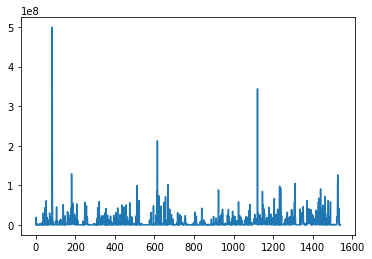

In [128]:
#print(coins)
#utc intervals for ranking event
d = 86400
h = int(d/24)
hhr = int(h/17)
print(len(coin),len(dates))

#print(coin.iloc[0])
t_dif = []
for i in range(0,len(coin)-1):
    t1 = coin['Date_m'].iloc[i]
    t2 = coin['Date_m'].iloc[i+1]
    td = (t2-t1)
    #if(td) signal logic
    t_dif.append(td)
t_dif.append(0)
t_dif_x = [x for x in range(len(t_dif))]
plt.plot(t_dif_x,t_dif)

plt.show()

## Test daily resampling for signal/event generation

https://alphascientist.com/feature_engineering.html

In [129]:
all_coins = pd.DataFrame()
for sym in coins:
    coin = cgroups.get_group(sym)
    #coin['t_dif1'] = coin['Date_m'].diff()
    #print(coin.head())
    #the secret sauce, extracting value from our data
    #for this example im using the time difference between the signal event occurence to determine enter/exits
    t_dif = []
    for i in range(0,len(coin)-1):
        t1 = coin['Date_m'].iloc[i]
        t2 = coin['Date_m'].iloc[i+1]
        td = (t2-t1)
        #if(td) signal logic
        t_dif.append(td)
    t_dif.append(0)
    #print(t_dif==coin['t_diff'])
    coin = coin.assign(t_dif = t_dif)
    coin.t_dif = coin.t_dif.shift(1)
    
    coin = coin.fillna(method='bfill')
    coin.t_dif = coin.t_dif.pct_change()
    coin = coin[['Close','t_dif']].copy()
    coin.Close = normalize(coin)
    coin.fillna(method='bfill')
    
    #make copy w/ no index for resample and hist data sync
    #create daily signals from intraday signal dataset
    dc = coin.reset_index().copy()
    dc.index = dc.Date
    #Daily resample
    daily_coin = dc.resample('D').sum()
    
    #daily resampled date index
    dates = list(daily_coin.index)
    print(sym)
    print(dates[0].strftime('%Y-%m-%d'),"   |   ",dates[-1].strftime('%Y-%m-%d'))
    prev_k,k = int(dates[0].timestamp()*1000), int(dates[-1].timestamp()*1000)
    
    #Download historical data
    c_hist = get_data(sym,prev_k,k,candle_k='1d')
    
    #extract signal for resampled signal dataframe and create signal column (-1,1) ...maybe (-1,0,1)
    c_hist['Close_diff'] = c_hist['Close'].diff().apply(np.sign)
    c_hist['bw_sig'] = daily_coin.t_dif
    c_hist['sig3'] = c_hist["bw_sig"].apply(np.sign)
    c_hist['sig3'] = c_hist['sig3'].replace(0,-1)
    c_hist = c_hist.fillna(0) 
    c_hist["daily_returns"] = (c_hist['Close']/c_hist['Open'])-1
    """
    #Visualize trading range and signal
    c_hist2 = c_hist[["Close","sig3"]].copy()
    c_hist2.Close = normalize(c_hist2,deci=True)
    c_hist2["High"] = normalize(c_hist,column="High",deci=True)
    c_hist2["Low"] = normalize(c_hist,column="Low",deci=True)
    c_hist2.plot(figsize=(8,5))
    #plt.savefig("/home/me/Pictures/{}range_signal.png".formate(sym))
    
    c_hist[['sig3','Close_diff']].plot(grid=True,figsize=(8,5))
    """

    #c_hist['Positions'] = c_hist['sig3'].diff()
    c_hist['Market Returns'] = np.log(c_hist['Close'] / c_hist['Close'].shift(1))
    c_hist['Strategy Returns'] = c_hist['Market Returns'] * c_hist['sig3'].shift(1)
    c_hist['Coin'] = sym
    c_hist = c_hist.reset_index()
    c_hist = c_hist.set_index(['Open time','Coin'])
    #print(c_hist)
    all_coins = pd.concat([all_coins,c_hist])

    #c_hist[['Market Returns','Strategy Returns']].cumsum().plot(grid=True,figsize=(8,5))    
    #plt.show()
    
    #cont = input("continue y/n: ")
    #if cont == 'n':
        #break


#monthly_return = c.resample('M').agg(lambda x: x[-1]/x[1] - 1)

DASHBTC
2018-08-24    |    2019-01-09
ENGBTC
2018-08-24    |    2019-01-09
THETABTC
2018-08-24    |    2019-01-09
APPCBTC
2018-08-24    |    2019-01-07
GVTBTC
2018-08-24    |    2019-01-09
OAXBTC
2018-08-24    |    2019-01-09
AIONBTC
2018-08-24    |    2019-01-07
HCBTC
2018-08-24    |    2019-01-09
WINGSBTC
2018-08-24    |    2018-12-31
POLYBTC
2018-08-24    |    2019-01-09
ARDRBTC
2018-08-24    |    2019-01-09
ZENBTC
2018-08-24    |    2019-01-09
CMTBTC
2018-08-24    |    2019-01-04
IOTABTC
2018-08-24    |    2019-01-09
NEBLBTC
2018-08-24    |    2019-01-09
ETHBTC
2018-08-24    |    2019-01-09
ICXBTC
2018-08-24    |    2019-01-08
LOOMBTC
2018-08-24    |    2019-01-09
NANOBTC
2018-08-24    |    2019-01-09
REPBTC
2018-08-24    |    2019-01-09
MODBTC
2018-08-24    |    2019-01-09
LSKBTC
2018-08-24    |    2019-01-09
BNBBTC
2018-08-24    |    2019-01-08
VIBEBTC
2018-08-24    |    2019-01-06
ELFBTC
2018-08-24    |    2019-01-09
MANABTC
2018-08-24    |    2019-01-06
WAVESBTC
2018-08-24    |

In [130]:
dts = all_coins.index.get_level_values(0)

fol = dts[0].strftime('%Y-%m-%d')+"_"+dts[-1].strftime('%Y-%m-%d')
print(fol)
fname = '/home/me/Documents/BWA/data/bw_portfolios/{}'.format(fol)
if os.path.exists(fname) == False:
    os.mkdir(fname)
    all_coins.to_csv(fname+"{}_day_int.csv".format("30"))
all_coins

2018-08-24_2019-01-09


,,Open,High,Low,Close,Close time,Volume,Close_diff,bw_sig,sig3,daily_returns,Market Returns,Strategy Returns
Open time,Coin,,,,,,,,,,,,
2018-08-24,DASHBTC,0.021539,0.022011,0.021108,0.021704,1.535155e+12,1.917544e+04,0.0,100.705387,1.0,0.007661,NaN,NaN
2018-08-25,DASHBTC,0.021702,0.021817,0.021200,0.021499,1.535242e+12,1.498299e+04,-1.0,174.461872,1.0,-0.009354,-0.009490,-0.009490
2018-08-26,DASHBTC,0.021477,0.021530,0.020856,0.021102,1.535328e+12,2.155820e+04,-1.0,94.187298,1.0,-0.017461,-0.018639,-0.018639
2018-08-27,DASHBTC,0.021089,0.027886,0.021013,0.026598,1.535414e+12,3.928787e+04,1.0,97.220673,1.0,0.261226,0.231468,0.231468
2018-08-28,DASHBTC,0.026593,0.028475,0.024780,0.027409,1.535501e+12,3.884743e+04,1.0,120.439360,1.0,0.030685,0.030035,0.030035
2018-08-29,DASHBTC,0.027362,0.028828,0.026361,0.026581,1.535587e+12,2.747572e+04,-1.0,0.000000,-1.0,-0.028543,-0.030675,-0.030675
2018-08-30,DASHBTC,0.026582,0.026841,0.025465,0.026515,1.535674e+12,1.745567e+04,-1.0,0.000000,-1.0,-0.002521,-0.002486,0.002486
2018-08-31,DASHBTC,0.026465,0.027878,0.026291,0.027698,1.535760e+12,1.870931e+04,1.0,0.000000,-1.0,0.046590,0.043650,-0.043650
2018-09-01,DASHBTC,0.027699,0.031530,0.027638,0.030890,1.535846e+12,3.477433e+04,1.0,0.000000,-1.0,0.115203,0.109072,-0.109072


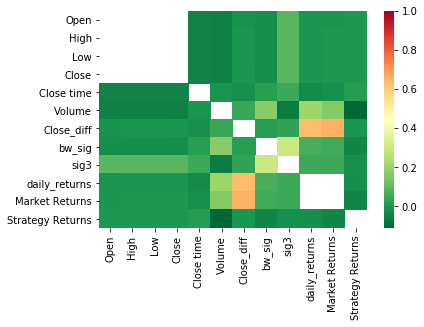

In [168]:
corr = all_coins.corr()
#print(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdYlGn_r', mask = (corr >= 0.9))

In [181]:
bench = get_data("BTCUSDT",int(unix_time_millis(dts[0])),int(unix_time_millis(dts[-1])),"1d")

In [184]:
cap = 10000

btc = np.log(bench['Close'] / bench['Close'].shift(1))
btc_returns = btc.cumsum().iloc[-1]
s_returns = all_coins['Strategy Returns'].cumsum().iloc[-1]
m_returns = all_coins['Market Returns'].cumsum().iloc[-1]

#hypothetical returns per strategy
s_value = cap+(cap*s_returns)
m_value = cap+(cap*m_returns)

#hypothetical growth of 10k
s_value_usd = cap+(s_value*btc_returns)
m_value_usd = cap+(m_value*btc_returns)
btc_value = cap+(cap*btc_returns) 

print("BW Portfolio Returns:\n\n| buy 'n hold: {}% \n| BW Strategy: {}% \n| BTC {}% ".format(m_returns,s_returns,btc_returns))
print("Performance w/ 10,000 starting value\n\n| buy 'n hold: {} \n| BW Strategy: {}\n| BTC {}".format(m_value_usd,s_value_usd,btc_value))

BW Portfolio Returns:

| buy 'n hold: -16.13165284696037% 
| BW Strategy: 0.45511384397221183% 
| BTC -0.5214415566383174% 
Performance w/ 10,000 starting value

| buy 'n hold: 88902.72615029642 
| BW Strategy: 2412.431721131642%
| BTC 4785.584433616827


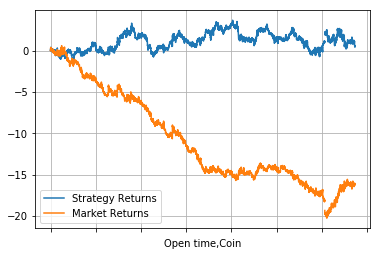

In [173]:

total_returns = all_coins[['Strategy Returns','Market Returns']].cumsum().plot(grid=True)
#fig = plt.figure()
#ax1 = fig.add_subplot(611)
#ax1 = total_returns.plot()

#ax2 = fig.add_subplot(612)


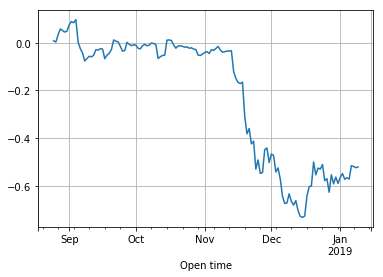

In [175]:
bench.cumsum().plot(grid=True)